# Building Gradient Boosting Models

Clone the repo at:
www.github.com/numeristical/resources

Navigate to folder: "Building_GB_Models"

Open the notebook file: "BuildGBModel.ipynb"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score
import xgboost as xgb
import seaborn as sns
import hyperopt as hp
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Ames Housing Data

We'll use the Ames housing data.  This is a small-ish (<3K) size data set of houses sold in Ames, Iowa from 2006 to 2010

In [3]:
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style   

In [4]:
df_house.sample(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2818,2819,908102330,20,RL,67.0,8877,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,4,5,1951,1951,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,Fa,No,LwQ,836.0,Unf,0.0,0.0,836.0,GasA,TA,Y,FuseF,1220,0,0,1220,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1951.0,Unf,2.0,396.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2006,COD,Normal,102000
585,586,534128190,60,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosA,Norm,1Fam,2Story,6,7,1967,1997,Gable,CompShg,MetalSd,MetalSd,BrkFace,256.0,TA,TA,PConc,TA,TA,No,Unf,0.0,Unf,0.0,932.0,932.0,GasA,Gd,Y,SBrkr,1271,1369,0,2640,0.0,0.0,2,1,5,1,Gd,8,Typ,1,TA,Attchd,1967.0,RFn,2.0,515.0,TA,TA,Y,0,120,0,0,168,0,NaN,NaN,NaN,0,5,2009,WD,Normal,256900
1373,1374,904100160,50,RL,115.0,21286,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1.5Fin,5,5,1948,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,720.0,720.0,GasA,TA,Y,SBrkr,720,551,0,1271,0.0,0.0,2,0,4,1,TA,7,Typ,1,Gd,Attchd,1948.0,Unf,1.0,312.0,TA,TA,Y,0,0,108,0,0,0,NaN,NaN,NaN,0,8,2008,WD,Normal,135000
2223,2224,909428180,20,RL,NaN,25485,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,4,1960,1960,Gable,CompShg,Wd Sdng,MetalSd,BrkFace,423.0,TA,Fa,CBlock,TA,Gd,Mn,LwQ,540.0,Rec,1020.0,0.0,1560.0,GasA,TA,Y,SBrkr,1560,0,0,1560,0.0,0.0,1,1,3,1,TA,6,Typ,3,TA,Attchd,1960.0,RFn,2.0,580.0,TA,TA,Y,0,75,584,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,201000
1329,1330,903204095,40,RM,50.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Feedr,1Fam,1Story,5,6,1930,1960,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,742.0,742.0,GasA,TA,Y,FuseA,779,0,156,935,0.0,0.0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1988.0,Unf,1.0,308.0,TA,TA,P,0,0,0,0,0,0,NaN,NaN,Shed,600,8,2008,WD,Normal,79500


In [5]:
# There are lots of features here...
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [6]:
# Let's focus on a smaller subset of features...
feat_1 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']


In [7]:
X = df_house.iloc[:,:-1]  # everything except Sale Price
y = df_house.SalePrice 

In [8]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [9]:
X.loc[:,feat_1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Half Bath       2925 non-null   int64  
 8   Bedroom AbvGr   2925 non-null   int64  
 9   Garage Area     2925 non-null   float64
 10  Fireplaces      2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


## Model Building Process
- ### Explore and interrogate your data
- ### Start with a simple baseline model
- ### Use early stopping, tune `max_depth` first
- ### Check where your model is doing poorly
- ### Try to engineer features to address model shortcomings
    - #### Use domain expertise / common knowledge
- ### Save "big" hyperparameter tuning until the end


### Explore and interrogate the data
- Look at data before modeling!
    - Understand the distribution of the target variable (and know its mean).
    - Explore relationships between the target and the features
    - Look for "idiosyncracies" or other artifacts in your data
    - Try to understand what different values "mean"
    - Sometimes variables have deeper meanings....
<br>
- For regression problems, the `pairplot` in the seaborn package is a nice way to look at all of the bivariate relationships.  



In [10]:
# Get the mean of your target variable
np.mean(df_house.SalePrice), np.min(df_house.SalePrice), np.max(df_house.SalePrice)

(180411.5747008547, 12789, 625000)

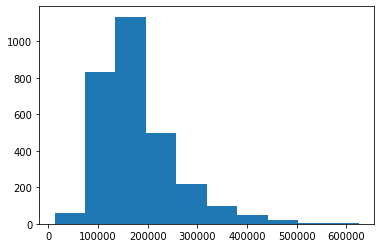

In [11]:
# Make a histogram - doesn't look great at first
plt.hist(df_house.SalePrice);

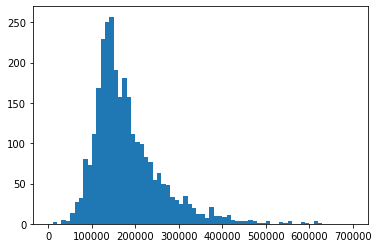

In [12]:
# Redo the histogram with "nicer" bins
binpts = np.linspace(0,700000, 70+1)
plt.hist(df_house.SalePrice, bins=binpts);

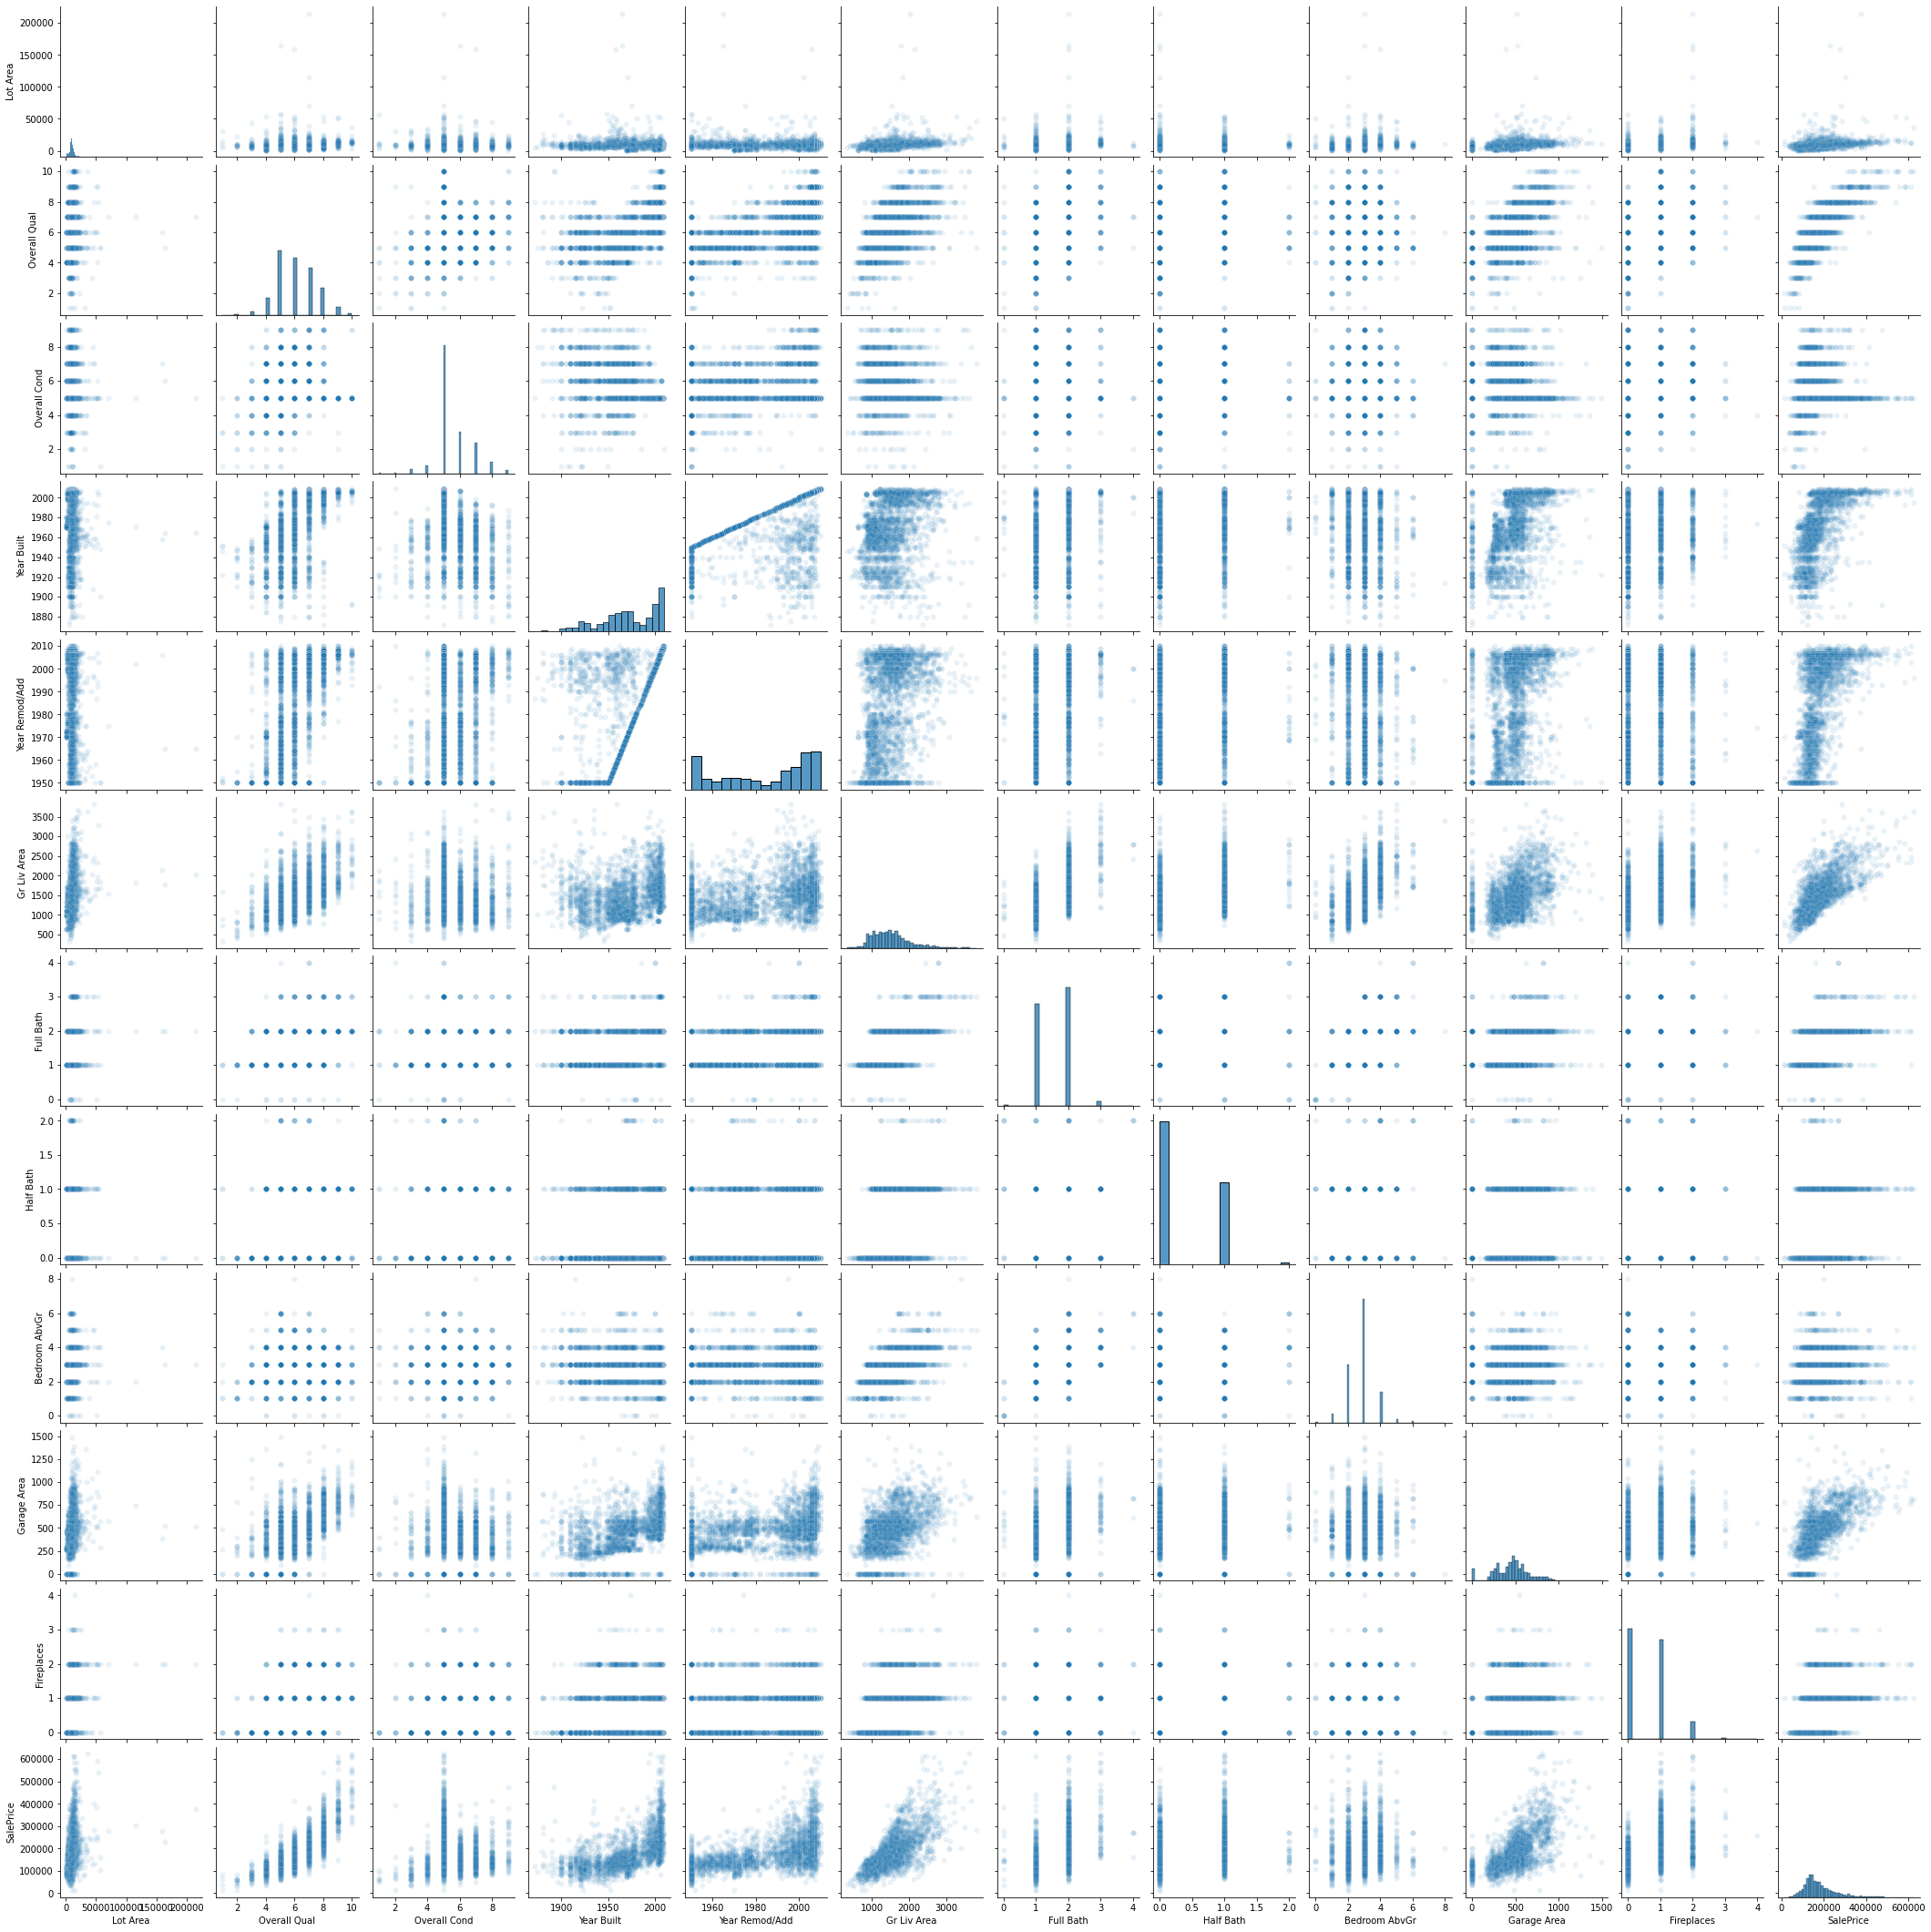

In [13]:
# do a pairplot - this may take a minute or two to complete
sns.pairplot(df_house.loc[:,feat_1+['SalePrice']], plot_kws={'alpha':.1});

## Questions
- What variables seem to have the strongest relationship with the SalePrice?
- What is going on with 'Year Built' and 'Year Remod/Add'?

(0.0, 30000.0)

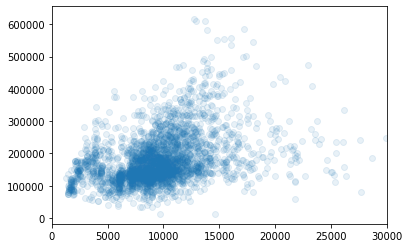

In [14]:
# Lot Area is hard to see due to outliers - let's plot it again here
plt.scatter(df_house['Lot Area'], df_house['SalePrice'], alpha=.1)
plt.xlim([0,30000])

## Start with a simple baseline model
- Often people start modeling by assembling all the relevant features, trying automated feature selection and massive grid searches to get the best model.
- This typically results in a model with lots of features that are basically irrelevant.
- It is costly to have lots of features in your model!
    - Every feature is a potential failure point
- In most cases, can get most of the performance from relatively few features


In [15]:
feat_0 = ['Lot Area',
 'Overall Qual',
 'Year Built',
 'Gr Liv Area',
 'Bedroom AbvGr']

In [16]:
# create data sets of just the smaller subset of features
X_train_0 = X_train_full.loc[:, feat_0]
X_test_0 = X_test_full.loc[:, feat_0]

In [17]:
# Create / train Random Forest on just 5 variables
rf0 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf0.fit(X_train_0, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [18]:
preds_rf0 = rf0.predict(X_test_0)

In [19]:
# Get RMSE and MAE of the predictions
np.sqrt(mean_squared_error(y_test, preds_rf0)), mean_absolute_error(y_test, preds_rf0), r2_score(y_test, preds_rf0)

(26317.97417463695, 18519.59049232197, 0.8740804261385133)

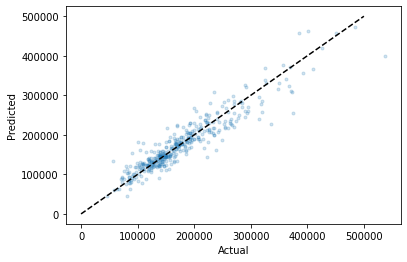

In [20]:
# Plot predicted (y) vs actual (x)
plt.scatter(x=y_test, y=preds_rf0, alpha=.2, marker='.')
plt.plot([0,500000],[0,500000], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted');

Now that we have a baseline of performance, we can make sure that the additional complexities (more features, GB instead of RF, etc.) are actually improving things.

Next, let's try the 11 feature model and see how much it improves our random forest.

In [21]:
# create data sets of the set of 11 features
X_train_1 = X_train_full.loc[:, feat_1]
X_test_1 = X_test_full.loc[:, feat_1]

In [22]:
# Create / train Random Forest on 11 variables
rf1 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf1.fit(X_train_1, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [23]:
preds_rf1 = rf1.predict(X_test_1)

In [24]:
# Get RMSE and MAE of the 11-feature RF predictions
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1), r2_score(y_test, preds_rf1)

(23187.739497069222, 16108.74036626533, 0.9022526127479905)

In [25]:
# Compare to previous predictions
np.sqrt(mean_squared_error(y_test, preds_rf0)), mean_absolute_error(y_test, preds_rf0), r2_score(y_test, preds_rf0)

(26317.97417463695, 18519.59049232197, 0.8740804261385133)

In [26]:
np.sqrt(mean_squared_error(y_test, preds_rf1))/np.sqrt(mean_squared_error(y_test, preds_rf0))

0.8810609564096166

This looks like a substantial improvement.  
- R2 from 87.3 -> 90.2.  
- 12% drop in RMSE

So we can feel confident the additional 6 variables are adding predictive power.

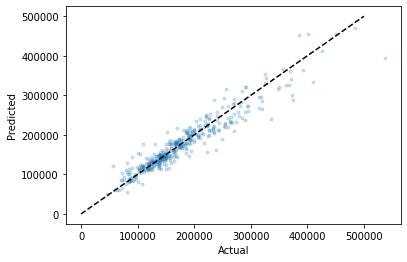

In [27]:
# Plot predicted (y) vs actual (x)
plt.scatter(y_test, preds_rf1, alpha=.2, marker='.')
plt.plot([0,500000],[0,500000], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted');

## Gradient Boosting Model Building
Now that we have a baseline to compare against, we can begin modeling with Gradient Boosting.  Having a baseline will help us determine the quality of our hyperparameter settings.

## XGBoost

For now, we will use the XGBoost package for Gradient Boosting.  XGBoost first came out in 2015.  The acronym is "eXtreme Gradient Boosting".  It implemented a number of theoretical and practical improvements, many of which have become standard in subsequent packages:

- *Native handling of missing data*: (Missing values are checked to see if they "fit" better on the left or right side of the tree for each split values)
- *Newton steps*: rather than just finding the gradient, XGBoost also looks at the second derivative to determine the step size.
- *Advanced Regularization*: XGBoost rederived the math to flexibly incorporate *shrinkage* (similar to Lasso/Ridge Regression) and penalize the number of splits.
- *Not checking every split*: XGBoost had a method for deriving quantiles to avoid checking every split (particularly in large datasets when a predictor has a large number of possible values).  Though not the default, this has since been shown to be effective both for speeding up the training *and* as another source of regularization
- *Distributed training*: XGBoost had implementations for working with large datasets that are not held in memory.

In [28]:
# First let's use an XGBoost model with default parameters
xgb_def = xgb.XGBRegressor()
xgb_def

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
xgb_def.fit(X_train_1, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [30]:
preds_xgb_def = xgb_def.predict(X_test_1)

In [31]:
np.sqrt(mean_squared_error(y_test, preds_xgb_def)), mean_absolute_error(y_test, preds_xgb_def), r2_score(y_test, preds_xgb_def)

(23693.223543591423, 16741.70330078125, 0.8979444479242334)

In [32]:
# Baseline 11-feature RF predictions
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1), r2_score(y_test, preds_rf1)

(23187.739497069222, 16108.74036626533, 0.9022526127479905)

- Note that we actually do **worse** than the Random Forest model when we use the default parameter settings.
- It is very difficult to get the number of trees / learning rate right without early stopping!


## Use Early Stopping!!

As we just saw, using the default parameters on gradient boosting can easily give you results that are not very good.  Here, it does worse than a simple Random Forest

However, this does NOT mean you need to do massive grid searches to get good results

As discussed in the Fundamentals of Gradient Boosting course:

- The three most important parameters in your boosting model are the *max_depth*, *learning_rate*, and *n_estimators*.  
- Setting these is made more challenging by the fact that they are highly interactive
- The best way to handle this is:
    - Set aside a validation set for early stopping
    - Use a low-ish `learning rate`
    - Use a high `n_estimators` (we will early stop)
    - Stop when performance on the validation set begins to degrade
    
XGBoost (like most other boosting packages) makes it easy to implement early stopping, as we demonstrate below:


In [33]:
# Set a big number of trees, and a small learning rate
# We will not actually fit so many trees, since the early stopping will kick in
xgb1 = xgb.XGBRegressor(n_estimators=5000, learning_rate=.01)


In [34]:
# Add trees until we show no improvement (i.e. no new low) for 10 trees
xgb1.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190622.94675
[1]	validation_0-rmse:188799.16001
[2]	validation_0-rmse:186988.57350
[3]	validation_0-rmse:185196.73902
[4]	validation_0-rmse:183442.80466
[5]	validation_0-rmse:181691.14089
[6]	validation_0-rmse:179967.47076
[7]	validation_0-rmse:178238.39707
[8]	validation_0-rmse:176540.64069
[9]	validation_0-rmse:174861.69277
[10]	validation_0-rmse:173203.03921
[11]	validation_0-rmse:171558.98288
[12]	validation_0-rmse:169934.59951
[13]	validation_0-rmse:168310.42499
[14]	validation_0-rmse:166720.47618
[15]	validation_0-rmse:165134.42401
[16]	validation_0-rmse:163563.97674
[17]	validation_0-rmse:162016.99210
[18]	validation_0-rmse:160483.75107
[19]	validation_0-rmse:158970.16473
[20]	validation_0-rmse:157458.84070
[21]	validation_0-rmse:155976.30539
[22]	validation_0-rmse:154511.63742
[23]	validation_0-rmse:153060.25445
[24]	validation_0-rmse:151621.30345
[25]	validation_0-rmse:150206.24369
[26]	validation_0-rmse:148796.90212
[27]	validation_0-rmse:147398.58461
[2

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[66]	validation_0-rmse:102813.97079
[67]	validation_0-rmse:101896.34084
[68]	validation_0-rmse:100984.60734
[69]	validation_0-rmse:100095.91066
[70]	validation_0-rmse:99200.95511
[71]	validation_0-rmse:98321.44402
[72]	validation_0-rmse:97455.74371
[73]	validation_0-rmse:96590.60885
[74]	validation_0-rmse:95740.80822
[75]	validation_0-rmse:94894.99838
[76]	validation_0-rmse:94060.97995
[77]	validation_0-rmse:93240.20507
[78]	validation_0-rmse:92427.56934
[79]	validation_0-rmse:91614.03045
[80]	validation_0-rmse:90814.76252
[81]	validation_0-rmse:90015.88635
[82]	validation_0-rmse:89231.38375
[83]	validation_0-rmse:88461.49698
[84]	validation_0-rmse:87697.81240
[85]	validation_0-rmse:86934.17172
[86]	validation_0-rmse:86176.74605
[87]	validation_0-rmse:85437.00773
[88]	validation_0-rmse:84693.88799
[89]	validation_0-rmse:83965.14510
[90]	validation_0-rmse:83256.12636
[91]	validation_0-rmse:82531.46297
[92]	validation_0-rmse:81824.03275
[93]	validation_0-rmse:81129.36567
[94]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
preds_xgb1 = xgb1.predict(X_test_1)


In [36]:
np.sqrt(mean_squared_error(y_test, preds_xgb1)), mean_absolute_error(y_test, preds_xgb1), r2_score(y_test, preds_xgb1)

(22922.514079901484, 15982.38033203125, 0.9044759276769831)

In [37]:
# Compared to last model
np.sqrt(mean_squared_error(y_test, preds_xgb_def)), mean_absolute_error(y_test, preds_xgb_def), r2_score(y_test, preds_xgb_def)

(23693.223543591423, 16741.70330078125, 0.8979444479242334)

In [38]:
# Baseline 11-feature RF predictions
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1), r2_score(y_test, preds_rf1)

(23187.739497069222, 16108.74036626533, 0.9022526127479905)

With early stopping we get a significant improvement over the default GB model and a slight improvement over the baseline RF model.

In [39]:
# Now let's tune the max depth

md_vals_vec=list(range(1,10))
rmse_vec = np.zeros(len(md_vals_vec))
for i,md in enumerate(md_vals_vec):
    print(f'Training with max_depth {md}')
    xgb_temp = xgb.XGBRegressor(max_depth=md, 
                        n_estimators=5000, learning_rate=.01, 
         early_stopping_rounds = 10) #, early_stopping_rounds=10)
    xgb_temp.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))
    
## Note - for newer versions of xgboost, this might scream at you....


Training with max_depth 1
Training with max_depth 2
Training with max_depth 3
Training with max_depth 4
Training with max_depth 5
Training with max_depth 6
Training with max_depth 7
Training with max_depth 8
Training with max_depth 9


21631.226970898882

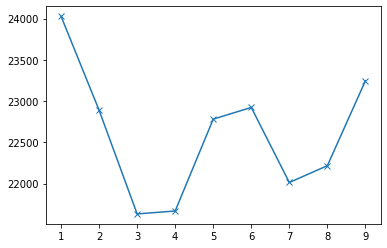

In [40]:
# Plot performance vs. max_depth
plt.plot(md_vals_vec, rmse_vec, marker='x')
np.min(rmse_vec)

Best `max_depth` is at 3, let's try re-training at that max_depth value

In [41]:
xgb2 = xgb.XGBRegressor(max_depth=3, n_estimators=5000, learning_rate=.01)


In [42]:
# Add trees until we show no improvement (i.e. no new low) for 10 trees
xgb2.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190653.30237
[1]	validation_0-rmse:188846.37132
[2]	validation_0-rmse:187053.02619
[3]	validation_0-rmse:185277.66577
[4]	validation_0-rmse:183520.96124
[5]	validation_0-rmse:181788.25382
[6]	validation_0-rmse:180066.54243
[7]	validation_0-rmse:178369.24698
[8]	validation_0-rmse:176682.60780
[9]	validation_0-rmse:175026.72264
[10]	validation_0-rmse:173373.79227
[11]	validation_0-rmse:171751.06728
[12]	validation_0-rmse:170126.74372
[13]	validation_0-rmse:168530.11266
[14]	validation_0-rmse:166951.98844
[15]	validation_0-rmse:165388.01579
[16]	validation_0-rmse:163847.60296
[17]	validation_0-rmse:162305.25993
[18]	validation_0-rmse:160802.33636
[19]	validation_0-rmse:159302.84663
[20]	validation_0-rmse:157824.59092
[21]	validation_0-rmse:156347.78874
[22]	validation_0-rmse:154902.02514
[23]	validation_0-rmse:153466.81923
[24]	validation_0-rmse:152051.26796
[25]	validation_0-rmse:150645.75448
[26]	validation_0-rmse:149258.54041
[27]	validation_0-rmse:147877.62849
[2

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-rmse:85985.17920
[89]	validation_0-rmse:85276.38764
[90]	validation_0-rmse:84564.54803
[91]	validation_0-rmse:83869.32071
[92]	validation_0-rmse:83169.90168
[93]	validation_0-rmse:82492.38279
[94]	validation_0-rmse:81825.21637
[95]	validation_0-rmse:81145.44161
[96]	validation_0-rmse:80465.04942
[97]	validation_0-rmse:79796.58310
[98]	validation_0-rmse:79131.22708
[99]	validation_0-rmse:78473.56802
[100]	validation_0-rmse:77825.86735
[101]	validation_0-rmse:77195.30393
[102]	validation_0-rmse:76559.24940
[103]	validation_0-rmse:75952.62303
[104]	validation_0-rmse:75330.79213
[105]	validation_0-rmse:74713.28571
[106]	validation_0-rmse:74117.35875
[107]	validation_0-rmse:73521.86316
[108]	validation_0-rmse:72951.18132
[109]	validation_0-rmse:72349.88577
[110]	validation_0-rmse:71771.97377
[111]	validation_0-rmse:71194.83762
[112]	validation_0-rmse:70615.62221
[113]	validation_0-rmse:70064.26189
[114]	validation_0-rmse:69499.03024
[115]	validation_0-rmse:68956.18616
[116

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [43]:
preds_xgb2 = xgb2.predict(X_test_1)


In [44]:
np.sqrt(mean_squared_error(y_test, preds_xgb2)), mean_absolute_error(y_test, preds_xgb2), r2_score(y_test, preds_xgb2)

(21631.226970898882, 15551.83689453125, 0.9149350519751327)

In [45]:
# Compared to previous model (un-tuned max_depth)
np.sqrt(mean_squared_error(y_test, preds_xgb1)), mean_absolute_error(y_test, preds_xgb1), r2_score(y_test, preds_xgb1)

(22922.514079901484, 15982.38033203125, 0.9044759276769831)

In [46]:
np.sqrt(mean_squared_error(y_test, preds_xgb2))/np.sqrt(mean_squared_error(y_test, preds_xgb1))

0.9436672999959108

We see a significant improvement in RMSE from tuning the `max_depth`

## Iterating and Improving the Model
Note that we are already iterating and improving our model!
<br>
We are following a cycle:
- Fit model
- Make predictions
- Evaluate the quality of our predictions
- Compare to previous models
- Make adjustments and repeat the cycle

However, thus far, we have just made simple "no-brainer" improvements - going from RF to GB, implementing early-stopping, tuning the max_depth.

Now, we start using our brains, our domain expertise to make further improvements.

## Failure Analysis
A great way to look for improvements is to examine the cases where the model made its biggest mistakes.

- Look at cases where the model performed poorly
- Try to understand why the model's prediction was so different from reality
- See if there is anything in the data that would reflect this reasoning
- Try to adjust model, add / engineer features to capture this useful information
- Rerun model and see if it improves!

In [47]:
# We calculate the residuals - discrepancies between true answer and prediction
# Positive residual => model underpredicted true value
# Negative residual => model overpredicted true value
resids = (y_test - preds_xgb2)
abs_resids = np.abs(resids)

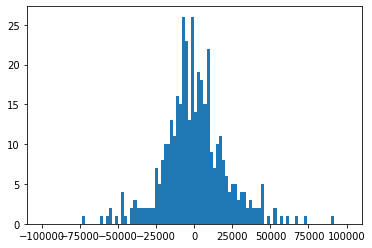

In [48]:
plt.hist(resids, bins = np.linspace(-100000,100000,101));

In [49]:
under_val_test = X_test_full.loc[resids>30000]
under_val_test

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
485,486,528280230,60,RL,NaN,12224,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,40.0,Gd,TA,PConc,Gd,TA,No,GLQ,695.0,Unf,0.0,297.0,992.0,GasA,Ex,Y,SBrkr,1022,1032,0,2054,1.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,BuiltIn,2000.0,RFn,2.0,390.0,TA,TA,Y,24,48,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
502,503,528385050,60,RL,79.0,9085,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,7,5,1995,1996,Gable,CompShg,VinylSd,VinylSd,BrkFace,286.0,Gd,TA,PConc,Gd,TA,No,GLQ,816.0,Unf,0.0,254.0,1070.0,GasA,Ex,Y,SBrkr,1094,967,0,2061,1.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,1995.0,Fin,2.0,647.0,TA,TA,Y,296,102,209,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal
1108,1109,528387050,60,RL,81.0,10944,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,7,5,1994,1994,Gable,CompShg,VinylSd,VinylSd,BrkFace,448.0,Gd,TA,PConc,Gd,TA,No,GLQ,1000.0,Unf,0.0,223.0,1223.0,GasA,Ex,Y,SBrkr,1223,904,0,2127,1.0,0.0,2,1,3,1,Gd,5,Typ,2,TA,Attchd,1994.0,RFn,2.0,525.0,TA,TA,Y,171,132,0,0,0,0,NaN,NaN,NaN,0,8,2008,WD,Normal
1856,1857,533252130,20,RL,90.0,10768,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Veenker,Norm,Norm,1Fam,1Story,5,8,1976,2004,Gable,CompShg,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Gd,ALQ,1157.0,Unf,0.0,280.0,1437.0,GasA,TA,Y,SBrkr,1437,0,0,1437,1.0,0.0,2,0,3,1,Gd,6,Typ,1,Fa,Attchd,1976.0,RFn,2.0,528.0,TA,TA,Y,0,21,0,0,180,0,NaN,NaN,NaN,0,7,2007,WD,Normal
2773,2774,907175030,20,RL,70.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,244.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1400.0,Unf,0.0,125.0,1525.0,GasA,Ex,Y,SBrkr,1525,0,0,1525,1.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2000.0,RFn,2.0,541.0,TA,TA,Y,219,36,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Normal
2261,2262,916384080,20,RL,64.0,9037,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,32.0,Gd,TA,PConc,Gd,TA,Av,GLQ,428.0,Unf,0.0,1048.0,1476.0,GasA,Ex,Y,SBrkr,1484,0,0,1484,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2006.0,RFn,2.0,472.0,TA,TA,Y,120,33,0,0,0,0,NaN,NaN,NaN,0,12,2007,WD,Normal
2800,2801,907290020,60,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,975.0,Unf,0.0,133.0,1108.0,GasA,Ex,Y,SBrkr,1108,989,0,2097,1.0,0.0,2,1,3,1,Gd,8,Typ,1,TA,Detchd,1998.0,RFn,2.0,583.0,TA,TA,Y,253,170,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2333,2334,527212040,60,RL,82.0,12438,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,8,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,466.0,Ex,TA,PConc,Ex,Gd,No,Unf,0.0,Unf,0.0,1234.0,1234.0,GasA,Ex,Y,SBrkr,1264,1312,0,2576,0.0,0.0,2,1,4,1,Ex,10,Typ,1,Gd,BuiltIn,2006.0,Fin,3.0,666.0,TA,TA,Y,324,100,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial
2316,2317,527108010,60,RL,134.0,19378,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,456.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,57.0,Unf,0.0,1335.0,1392.0,GasA,Ex,Y,SB

In [50]:
over_val_test = X_test_full.loc[resids<-30000]
over_val_test

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
1462,1463,907260010,60,RL,NaN,11250,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,Unf,0.0,Unf,0.0,1128.0,1128.0,GasA,Ex,Y,SBrkr,1149,1141,0,2290,0.0,0.0,2,1,4,1,Gd,9,Typ,1,Gd,Attchd,2002.0,Unf,2.0,779.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
628,629,535126100,20,RL,120.0,13560,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,3,1968,1968,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,216.0,TA,TA,CBlock,Fa,Fa,No,Unf,0.0,Unf,0.0,1392.0,1392.0,GasA,Gd,Y,SBrkr,1392,0,0,1392,1.0,0.0,1,0,2,1,TA,5,Maj2,2,TA,Attchd,1968.0,RFn,2.0,576.0,TA,TA,Y,0,0,240,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
104,105,533238045,20,FV,57.0,12853,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2010,2010,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Ex,Po,No,GLQ,1032.0,Unf,0.0,610.0,1642.0,GasA,Ex,Y,SBrkr,1418,0,0,1418,1.0,0.0,1,1,1,1,Gd,6,Typ,1,Gd,Attchd,2010.0,RFn,3.0,852.0,TA,TA,Y,160,192,0,224,0,0,NaN,NaN,NaN,0,4,2010,New,Partial
2513,2514,533223110,160,FV,NaN,4447,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Somerst,Norm,Norm,TwnhsE,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,530.0,530.0,GasA,Ex,Y,SBrkr,530,550,0,1080,0.0,0.0,2,1,2,1,Gd,4,Typ,0,NaN,Attchd,2003.0,RFn,2.0,496.0,TA,TA,Y,0,50,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
900,901,908275110,20,RL,70.0,11767,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,5,1956,1956,Hip,CompShg,HdBoard,HdBoard,BrkFace,259.0,TA,TA,CBlock,TA,TA,No,Rec,546.0,Unf,0.0,604.0,1150.0,GasA,Ex,Y,SBrkr,1560,0,0,1560,0.0,0.0,1,0,2,1,TA,7,Min1,1,TA,Attchd,1956.0,Unf,1.0,313.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
2381,2382,528106120,20,RL,110.0,16163,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,232.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,1618.0,1618.0,GasA,Ex,Y,SBrkr,1618,0,0,1618,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2004.0,Fin,3.0,880.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
1052,1053,528104050,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.0,Ex,TA,PConc,Ex,TA,Av,GLQ,1636.0,Unf,0.0,442.0,2078.0,GasA,Ex,Y,SBrkr,2084,0,0,2084,1.0,0.0,2,0,2,1,Ex,7,Typ,1,Gd,Attchd,2007.0,Fin,3.0,1220.0,TA,TA,Y,188,45,0,0,0,0,NaN,NaN,NaN,0,6,2008,New,Partial
2331,2332,527210050,60,RL,63.0,12292,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2006,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,184.0,Gd,TA,PConc,Ex,Gd,Gd,GLQ,205.0,Unf,0.0,889.0,1094.0,GasA,Ex,Y,SBrkr,1102,1371,0,2473,0.0,0.0,2,1,4,1,Gd,11,Typ,1,Gd,BuiltIn,2006.0,Fin,3.0,675.0,TA,TA,Y,246,39,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial
2335,2336,527216010,60,RL,92.0,15922,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,VinylSd,VinylSd,BrkFace,550.0,Gd,TA,PConc,Ex,TA,Av,Unf,0.0,Unf,0.0,1390.0,1390.0,GasA,Ex,Y,SBrkr,1390,1405,0,2795,0.0,0

In [51]:
feat_3 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'BsmtFin SF 1']#, 'BsmtFin SF 2']

X_train_3 = X_train_full.loc[:, feat_3]
X_test_3 = X_test_full.loc[:, feat_3]

In [52]:
xgb3 = xgb.XGBRegressor(max_depth=3, n_estimators=5000, learning_rate=.01)


In [53]:
# Add trees until we show no improvement (i.e. no new low) for 10 trees
xgb3.fit(X_train_3, y_train, 
         eval_set=[(X_test_3, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190653.30237
[1]	validation_0-rmse:188846.37132
[2]	validation_0-rmse:187053.02619
[3]	validation_0-rmse:185277.66577
[4]	validation_0-rmse:183520.96124
[5]	validation_0-rmse:181788.25382
[6]	validation_0-rmse:180066.54243
[7]	validation_0-rmse:178369.24698
[8]	validation_0-rmse:176682.60780
[9]	validation_0-rmse:175026.72264
[10]	validation_0-rmse:173373.79227
[11]	validation_0-rmse:171751.06728
[12]	validation_0-rmse:170126.74372
[13]	validation_0-rmse:168530.11266
[14]	validation_0-rmse:166951.98844
[15]	validation_0-rmse:165388.01579
[16]	validation_0-rmse:163847.60296
[17]	validation_0-rmse:162305.25993
[18]	validation_0-rmse:160802.33636
[19]	validation_0-rmse:159302.84663
[20]	validation_0-rmse:157824.59092
[21]	validation_0-rmse:156347.78874
[22]	validation_0-rmse:154902.02514
[23]	validation_0-rmse:153466.81923
[24]	validation_0-rmse:152051.26796
[25]	validation_0-rmse:150645.75448
[26]	validation_0-rmse:149258.54041
[27]	validation_0-rmse:147877.62849
[2

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[88]	validation_0-rmse:85612.91795
[89]	validation_0-rmse:84864.12095
[90]	validation_0-rmse:84140.74381
[91]	validation_0-rmse:83410.46956
[92]	validation_0-rmse:82707.60717
[93]	validation_0-rmse:81983.23856
[94]	validation_0-rmse:81287.56758
[95]	validation_0-rmse:80588.72580
[96]	validation_0-rmse:79894.26242
[97]	validation_0-rmse:79209.48695
[98]	validation_0-rmse:78551.93455
[99]	validation_0-rmse:77874.20593
[100]	validation_0-rmse:77213.31194
[101]	validation_0-rmse:76581.19089
[102]	validation_0-rmse:75926.36324
[103]	validation_0-rmse:75293.95715
[104]	validation_0-rmse:74660.51444
[105]	validation_0-rmse:74059.38824
[106]	validation_0-rmse:73433.50282
[107]	validation_0-rmse:72814.10061
[108]	validation_0-rmse:72218.88821
[109]	validation_0-rmse:71607.42301
[110]	validation_0-rmse:71012.35549
[111]	validation_0-rmse:70428.88724
[112]	validation_0-rmse:69849.69130
[113]	validation_0-rmse:69291.01890
[114]	validation_0-rmse:68712.23776
[115]	validation_0-rmse:68147.15113
[116

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [54]:
preds_xgb3 = xgb3.predict(X_test_3)


In [55]:
np.sqrt(mean_squared_error(y_test, preds_xgb3)), mean_absolute_error(y_test, preds_xgb3), r2_score(y_test, preds_xgb3)

(20331.673577604797, 14631.683544921874, 0.9248490301787095)

In [56]:
np.sqrt(mean_squared_error(y_test, preds_xgb2)), mean_absolute_error(y_test, preds_xgb2), r2_score(y_test, preds_xgb2)

(21631.226970898882, 15551.83689453125, 0.9149350519751327)

In [57]:
feat_3a = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'BsmtFin SF 1', 'BsmtFin SF 2']

X_train_3a = X_train_full.loc[:, feat_3a]
X_test_3a = X_test_full.loc[:, feat_3a]

In [58]:
xgb3a = xgb.XGBRegressor(max_depth=3, n_estimators=5000, learning_rate=.01)


In [59]:
# Add trees until we show no improvement (i.e. no new low) for 10 trees
xgb3a.fit(X_train_3a, y_train, 
         eval_set=[(X_test_3a, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190653.30237
[1]	validation_0-rmse:188846.37132
[2]	validation_0-rmse:187053.02619
[3]	validation_0-rmse:185277.66577
[4]	validation_0-rmse:183520.96124
[5]	validation_0-rmse:181788.25382
[6]	validation_0-rmse:180066.54243
[7]	validation_0-rmse:178369.24698
[8]	validation_0-rmse:176682.60780
[9]	validation_0-rmse:175026.72264
[10]	validation_0-rmse:173373.79227
[11]	validation_0-rmse:171751.06728
[12]	validation_0-rmse:170126.74372
[13]	validation_0-rmse:168530.11266
[14]	validation_0-rmse:166951.98844
[15]	validation_0-rmse:165388.01579
[16]	validation_0-rmse:163847.60296
[17]	validation_0-rmse:162305.25993
[18]	validation_0-rmse:160802.33636
[19]	validation_0-rmse:159302.84663
[20]	validation_0-rmse:157824.59092
[21]	validation_0-rmse:156347.78874
[22]	validation_0-rmse:154902.02514
[23]	validation_0-rmse:153466.81923
[24]	validation_0-rmse:152051.26796
[25]	validation_0-rmse:150645.75448
[26]	validation_0-rmse:149258.54041
[27]	validation_0-rmse:147877.62849
[2

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[74]	validation_0-rmse:96690.86943
[75]	validation_0-rmse:95849.21623
[76]	validation_0-rmse:95011.61804
[77]	validation_0-rmse:94192.24552
[78]	validation_0-rmse:93374.49236
[79]	validation_0-rmse:92570.05288
[80]	validation_0-rmse:91775.99703
[81]	validation_0-rmse:90983.29861
[82]	validation_0-rmse:90206.43156
[83]	validation_0-rmse:89424.87001
[84]	validation_0-rmse:88629.43049
[85]	validation_0-rmse:87872.25036
[86]	validation_0-rmse:87098.79517
[87]	validation_0-rmse:86361.68939
[88]	validation_0-rmse:85612.91795
[89]	validation_0-rmse:84864.12095
[90]	validation_0-rmse:84140.74381
[91]	validation_0-rmse:83410.46956
[92]	validation_0-rmse:82707.60717
[93]	validation_0-rmse:81983.23856
[94]	validation_0-rmse:81287.56758
[95]	validation_0-rmse:80588.72580
[96]	validation_0-rmse:79894.26242
[97]	validation_0-rmse:79209.48695
[98]	validation_0-rmse:78551.93455
[99]	validation_0-rmse:77874.20593
[100]	validation_0-rmse:77213.31194
[101]	validation_0-rmse:76581.19089
[102]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [60]:
preds_xgb3a = xgb3a.predict(X_test_3a)


In [61]:
np.sqrt(mean_squared_error(y_test, preds_xgb3a)), mean_absolute_error(y_test, preds_xgb3a), r2_score(y_test, preds_xgb3a)

(20082.116654418976, 14346.159296875, 0.9266825581423099)

In [62]:
np.sqrt(mean_squared_error(y_test, preds_xgb3)), mean_absolute_error(y_test, preds_xgb3), r2_score(y_test, preds_xgb3)

(20331.673577604797, 14631.683544921874, 0.9248490301787095)

In [63]:
X_train_full['BsmtFinSFtotal'] = X_train_full['BsmtFin SF 1']+X_train_full['BsmtFin SF 2']
X_test_full['BsmtFinSFtotal'] = X_test_full['BsmtFin SF 1']+X_test_full['BsmtFin SF 2']


In [64]:
feat_4 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'BsmtFinSFtotal']

X_train_4 = X_train_full.loc[:, feat_4]
X_test_4 = X_test_full.loc[:, feat_4]

In [65]:
xgb4 = xgb.XGBRegressor(max_depth=3, n_estimators=5000, learning_rate=.01)


In [66]:
# Add trees until we show no improvement (i.e. no new low) for 10 trees
xgb4.fit(X_train_4, y_train, 
         eval_set=[(X_test_4, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190653.30237
[1]	validation_0-rmse:188846.37132
[2]	validation_0-rmse:187053.02619
[3]	validation_0-rmse:185277.66577
[4]	validation_0-rmse:183520.96124
[5]	validation_0-rmse:181788.25382
[6]	validation_0-rmse:180066.54243
[7]	validation_0-rmse:178369.24698
[8]	validation_0-rmse:176682.60780
[9]	validation_0-rmse:175026.72264
[10]	validation_0-rmse:173373.79227
[11]	validation_0-rmse:171751.06728
[12]	validation_0-rmse:170126.74372
[13]	validation_0-rmse:168530.11266
[14]	validation_0-rmse:166951.98844
[15]	validation_0-rmse:165388.01579
[16]	validation_0-rmse:163847.60296
[17]	validation_0-rmse:162305.25993
[18]	validation_0-rmse:160802.33636
[19]	validation_0-rmse:159302.84663
[20]	validation_0-rmse:157824.59092
[21]	validation_0-rmse:156347.78874
[22]	validation_0-rmse:154902.02514
[23]	validation_0-rmse:153466.81923
[24]	validation_0-rmse:152051.26796
[25]	validation_0-rmse:150645.75448
[26]	validation_0-rmse:149258.54041
[27]	validation_0-rmse:147877.62849
[2

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[78]	validation_0-rmse:93524.66095
[79]	validation_0-rmse:92708.57474
[80]	validation_0-rmse:91914.76398
[81]	validation_0-rmse:91117.96052
[82]	validation_0-rmse:90335.42810
[83]	validation_0-rmse:89563.04672
[84]	validation_0-rmse:88813.37900
[85]	validation_0-rmse:88027.55538
[86]	validation_0-rmse:87281.70516
[87]	validation_0-rmse:86551.59933
[88]	validation_0-rmse:85784.86311
[89]	validation_0-rmse:85047.48595
[90]	validation_0-rmse:84299.87752
[91]	validation_0-rmse:83599.63417
[92]	validation_0-rmse:82869.26517
[93]	validation_0-rmse:82183.99437
[94]	validation_0-rmse:81469.41890
[95]	validation_0-rmse:80797.61586
[96]	validation_0-rmse:80097.41637
[97]	validation_0-rmse:79406.27822
[98]	validation_0-rmse:78754.12759
[99]	validation_0-rmse:78110.80823
[100]	validation_0-rmse:77442.86520
[101]	validation_0-rmse:76785.03791
[102]	validation_0-rmse:76164.74174
[103]	validation_0-rmse:75518.91766
[104]	validation_0-rmse:74894.37229
[105]	validation_0-rmse:74260.14182
[106]	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [67]:
preds_xgb4 = xgb4.predict(X_test_4)


In [68]:
np.sqrt(mean_squared_error(y_test, preds_xgb4)), mean_absolute_error(y_test, preds_xgb4), r2_score(y_test, preds_xgb4)

(19906.805849862452, 14317.11787109375, 0.9279570489797238)

## Hyperparameter Optimization

### Practical Considerations
- How much is it worth to improve (metric) by x ? (From a business / practical point of view)
- How much time / computing do I want to spend on improvement?
- How often will I be re-training / re-implementing this model?
- What is the value of knowing / understanding this dataset / model really well?


## Setting Parameters in Gradient Boosting
There are several approaches to finding the best parameters for your Gradient Boosting Model
1. Do a massive "grid search"
2. Just play around manually
3. "Smart" parameter search that tries to search promising combinations

There are drawbacks to all of these:
- Grid search is extremely time consuming
- It is difficult to know if you are choosing appropriate parameters and ranges
- There may be other considerations than just metric performance (model size, coherence, training time)
- Manual approaches are haphazard, attention consuming
- Smart approaches are not always as smart as they could be

In [69]:
# Now let's tune the max depth

md_vals_vec=list(range(1,10))
rmse_vec = np.zeros(len(md_vals_vec))
for i,md in enumerate(md_vals_vec):
    print(f'Training with max_depth {md}')
    xgb_temp = xgb.XGBRegressor(max_depth=md, 
                        n_estimators=5000, learning_rate=.01, 
         early_stopping_rounds = 10) #, early_stopping_rounds=10)
    xgb_temp.fit(X_train_4, y_train, 
         eval_set=[(X_test_4, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_4)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))
    
## Note - for newer versions of xgboost, this might scream at you....


Training with max_depth 1
Training with max_depth 2
Training with max_depth 3
Training with max_depth 4
Training with max_depth 5
Training with max_depth 6
Training with max_depth 7
Training with max_depth 8
Training with max_depth 9


19565.461672712583

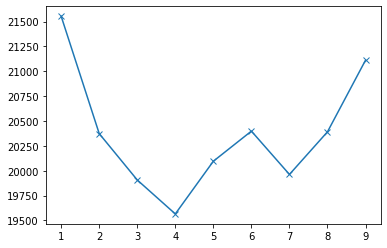

In [70]:
# Plot performance vs. max_depth
plt.plot(md_vals_vec, rmse_vec, marker='x')
np.min(rmse_vec)

## Let's manually explore some parameters one by one...

In [71]:
param_vals_vec=[.7,.75,.8,.85,.9,.95,1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_4, y_train, 
         eval_set=[(X_test_4, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_4)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

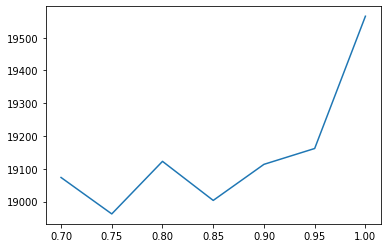

In [72]:
plt.plot(param_vals_vec, rmse_vec)

In [73]:

param_vals_vec=[.2,.3,.4,.5,.6,.7, .8,.9, 1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=.75, colsample_bynode=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_4, y_train, 
         eval_set=[(X_test_4, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_4)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

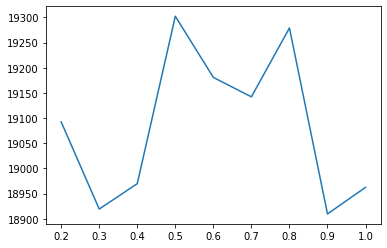

In [74]:
plt.plot(param_vals_vec, rmse_vec);

In [75]:
np.min(rmse_vec)

18909.5559833478

In [76]:

param_vals_vec=[.01,.1,1,2,3,5,10,20]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=.75, colsample_bynode=.9, reg_lambda=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_4, y_train, 
         eval_set=[(X_test_4, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_4)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

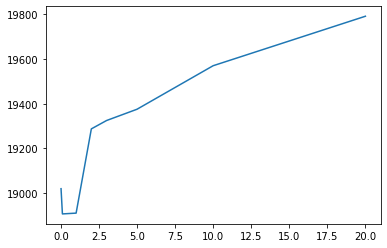

In [77]:
plt.plot(param_vals_vec, rmse_vec);

In [78]:
np.min(rmse_vec)

18905.9961174838

### Hyperopt Package
Idea: rather than try and exhaustively search a huge parameter space, focus the search on "promising" areas of the search space (based on what you have seen so far).

The `hyperopt` package can be a bit confusing and has some limitations, but overall does a reasonably good job of seraching the parameter space.

Let's see it in action

In [79]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

- First we must define the "loss function"
- This takes a set of parameters and output the loss value

In [80]:
def eval_model(params):
    xgb_base = xgb.XGBRegressor()
    xgb_base.set_params(**params)
    xgb_base.set_params(**{'learning_rate':.01,
                            'n_estimators': 10000,
                            'early_stopping_rounds':20},)
    xgb_base.fit(X_train_4, y_train, eval_set=[(X_test_4, y_test)], 
                 verbose=False)
    preds = xgb_base.predict(X_test_4)
    return(np.sqrt(mean_squared_error(y_test, preds)))

- Next, we define the parameter space.  
- There are several options to define ranges.
    - `randint`: chooses a random integer between a lower and an upper bound
    - `choice`: choose from a set of specific values
    - `uniform`: choose a (float) in the range
    - `quniform`: choose a discrete range of floats
    
See more at hyperopt documentation:
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/


In [81]:
fspace1 = {
    'max_depth':hp.randint('max_depth', 2, 6), # Pythonic - means 2 through 5 inclusive
    'colsample_bynode': hp.quniform('colsample_bynode',.1,1,.1),
    'subsample': hp.quniform('subsample',.3,1,.05),
    'reg_lambda': hp.qloguniform('reg_lambda',np.log(.1),np.log(20),.1)
}

- Finally, we use the `fmin` function and record our trials in a `Trials` object
- you can also specify which algorithm to use (http://hyperopt.github.io/hyperopt/#algorithms) (`tpe.suggest` is "Tree of Parzen Estimators") 


In [82]:
trials1 = Trials()
best = fmin(fn=eval_model, space=fspace1, algo=tpe.suggest, max_evals=100, trials=trials1)

100%|████████| 100/100 [02:12<00:00,  1.32s/trial, best loss: 18643.64880341397]


In [83]:
best

{'colsample_bynode': 0.4,
 'max_depth': 5,
 'reg_lambda': 1.2000000000000002,
 'subsample': 0.7000000000000001}

In [84]:
eval_model(best)

18643.64880341397

In [85]:
trials1.trials[:3]

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 19963.89881402573, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bynode': [0],
    'max_depth': [0],
    'reg_lambda': [0],
    'subsample': [0]},
   'vals': {'colsample_bynode': [0.6000000000000001],
    'max_depth': [2],
    'reg_lambda': [9.4],
    'subsample': [1.0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 8, 24, 19, 56, 9, 545000),
  'refresh_time': datetime.datetime(2023, 8, 24, 19, 56, 12, 420000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 20291.137787163356, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bynode': [1],
    'max_depth': [1],
    'reg_lambda': [1],
    'subsample': [1]},
   'vals': {'colsample_bynode': [0.2],
    'max_depth': [2],
    'reg_lambda': [0.8],
   

In [86]:
md_trial_vals = np.array([t['misc']['vals']['max_depth'] for t in trials1.trials])
csbn_trial_vals = np.array([t['misc']['vals']['colsample_bynode'] for t in trials1.trials])
ss_trial_vals = np.array([t['misc']['vals']['subsample'] for t in trials1.trials])
lambda_trial_vals = np.array([t['misc']['vals']['reg_lambda'] for t in trials1.trials])
loss_trial_vals = np.array([t['result']['loss'] for t in trials1.trials])
trial_nums = np.array([t['tid'] for t in trials1.trials])

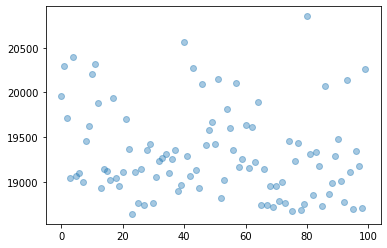

In [87]:
plt.scatter(trial_nums, loss_trial_vals, alpha=.4);

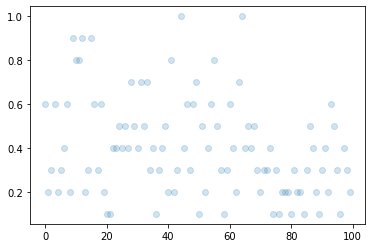

In [88]:
plt.scatter(trial_nums, csbn_trial_vals, alpha=.2);

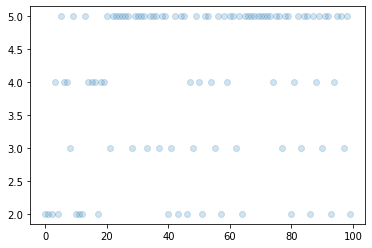

In [89]:
plt.scatter(trial_nums, md_trial_vals, alpha=.2);

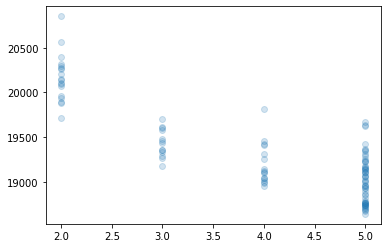

In [90]:
plt.scatter(md_trial_vals, loss_trial_vals, alpha=.2);

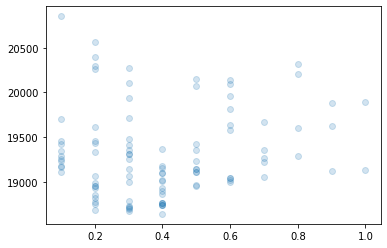

In [91]:
plt.scatter(csbn_trial_vals, loss_trial_vals, alpha=.2);

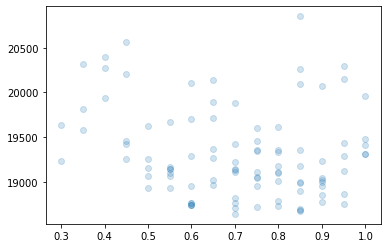

In [92]:
plt.scatter(ss_trial_vals, loss_trial_vals, alpha=.2);

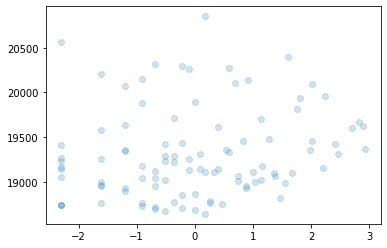

In [93]:
plt.scatter(np.log(lambda_trial_vals), loss_trial_vals, alpha=.2);

In [94]:
fspace2 = {
    'max_depth':hp.randint('max_depth', 4, 9), # Pythonic - means 4 through 8 inclusive
    'colsample_bynode': hp.quniform('colsample_bynode',.1,1,.1),
    'subsample': hp.quniform('subsample',.3,1,.05),
    'reg_lambda': hp.qloguniform('reg_lambda',np.log(.1),np.log(20),.1),

}

- Finally, we use the `fmin` function and record our trials in a `Trials` object
- you can also specify which algorithm to use (http://hyperopt.github.io/hyperopt/#algorithms) (`tpe.suggest` is "Tree of Parzen Estimators") 


In [95]:
trials2 = Trials()
best2 = fmin(fn=eval_model, space=fspace2, algo=tpe.suggest, max_evals=200, trials=trials2)

100%|███████| 200/200 [06:30<00:00,  1.95s/trial, best loss: 18676.217177335864]


In [96]:
best2

{'colsample_bynode': 0.30000000000000004,
 'max_depth': 8,
 'reg_lambda': 1.4000000000000001,
 'subsample': 0.30000000000000004}

In [97]:
md_trial_vals = np.array([t['misc']['vals']['max_depth'] for t in trials2.trials])
csbn_trial_vals = np.array([t['misc']['vals']['colsample_bynode'] for t in trials2.trials])
ss_trial_vals = np.array([t['misc']['vals']['subsample'] for t in trials2.trials])
lambda_trial_vals = np.array([t['misc']['vals']['reg_lambda'] for t in trials2.trials])
loss_trial_vals = np.array([t['result']['loss'] for t in trials2.trials])
trial_nums = np.array([t['tid'] for t in trials2.trials])

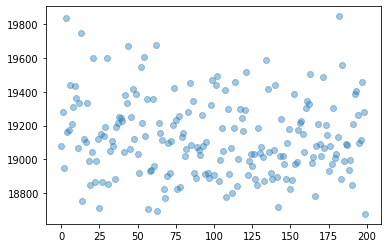

In [98]:
plt.scatter(trial_nums, loss_trial_vals, alpha=.4);

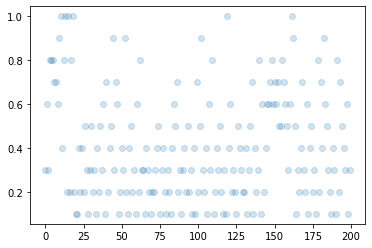

In [99]:
plt.scatter(trial_nums, csbn_trial_vals, alpha=.2);

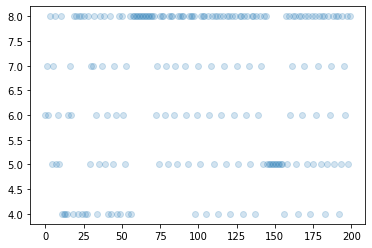

In [100]:
plt.scatter(trial_nums, md_trial_vals, alpha=.2);

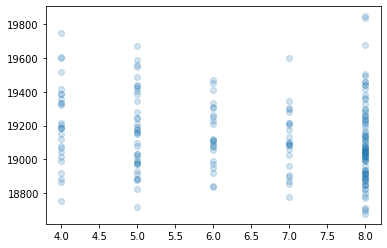

In [101]:
plt.scatter(md_trial_vals, loss_trial_vals, alpha=.2);

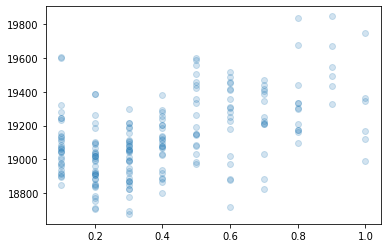

In [102]:
plt.scatter(csbn_trial_vals, loss_trial_vals, alpha=.2);

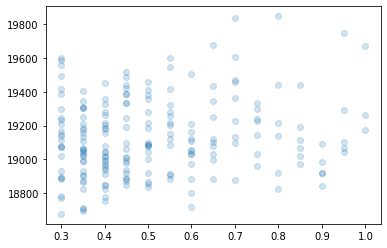

In [103]:
plt.scatter(ss_trial_vals, loss_trial_vals, alpha=.2);

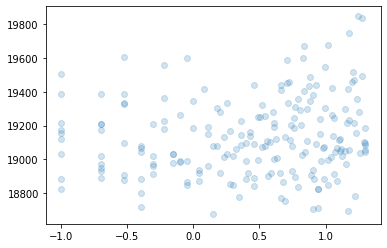

In [104]:
plt.scatter(np.log10(lambda_trial_vals), loss_trial_vals, alpha=.2);

At this point, we can decide to use the parameter set that worked best.

In [105]:
xgb_final = xgb.XGBRegressor()
xgb_final.set_params(**best2)
xgb_final.set_params(**{'learning_rate':.01,
                        'n_estimators': 10000,
                        'early_stopping_rounds':20},)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=0.30000000000000004,
             colsample_bytree=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [106]:
xgb_final.fit(X_train_4, y_train, eval_set=[(X_test_4, y_test)], 
             verbose=False)
preds = xgb_final.predict(X_test_4)
np.sqrt(mean_squared_error(y_test, preds))

18676.217177335864

# Final comments on parameter search
- This example was a quite small dataset (~3000 data points), so we were able to run many iterations very quickly.  Typically these searches will take much longer, so it is more important to choose smart ranges.
- Note that lots of combinations gave very good results.  Typically if you get the `max_depth` right (using early stopping) and then pick "pretty good" values for the rest, you will be in good shape
- In practice, other considerations (e.g. model size, parsimony) may come into play.  Generally, you want to pick a "simpler" model if the difference in performance is negligible